In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys  
import os
from itertools import cycle,product
import import_ipynb
import datetime as dt
import warnings
warnings.filterwarnings('error')
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../../Demand')
sys.path.insert(0, '../../PV_model/src')
from get_demand import get_demand as dem
import get_pv
import P2P_functions as p2p

In [2]:
community_size=100
timestep=0.25 # in hours 0.25 is 15 minute
seed=1
country_code='DE'
pv_penetration=50
batt_penetration=50
retail_price=0.28
export_price=0.04
predet_bhv='low'#'high','low',False
#ILR=1.2

In [3]:
df,meta=dem(country_code)
pv=get_pv.get_pv(country_code,timestep)
if (timestep>0.25) & (country_code in ['DE','CH','US','UK']):
    if timestep==0.5:
        df=df.resample('30T').sum()*2 # from kWh to kW
        pv=pv*2
    elif timestep==1:
        df=df.resample('1H').sum() # from kWh to kW
        
elif (timestep>0.5) & (country_code in ['IE']):
    if timestep==1:
        df=df.resample('1H').sum() # from kWh to kW
elif timestep==0.25:
    df=df*4 # from kWh to kW
    pv=pv*4
else:
    print('country or timestep not supported')
pv_dist=get_pv.get_pv_ditribution(country_code,mean=4)
df_out=pd.concat([df,pv],axis=1)




----------------------------------
Country: DE
Data resolution: 15.0
Original year: 2010.0
Sample size: 74.0
Average consumption per year: 4685.069393693686
Country: DE
Total generation per year: PV    1535.83138
dtype: float64
Capacity factor: PV    17.53
dtype: float64%
Country: DE


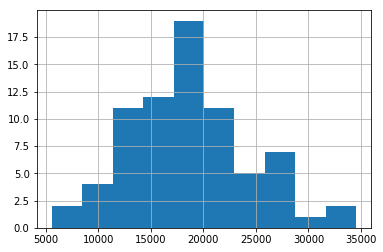

In [4]:
(df_out.iloc[:,:-1].sum()).hist()

In [5]:
df_com=pd.DataFrame(df_out.loc[:,(df_out.sum()<(10000/timestep))].iloc[:,:-1].sample(n=community_size,replace=True,random_state=seed,axis=1).columns)
selection=pd.concat([pv_dist.round(1).sample(n=community_size,random_state=seed).reset_index(drop=True),df_com],axis=1)
selection.columns=['PV_size','name']
list_pv_penetration=[100,75,50,25]# %
list_batt_penetration=[100,75,50,25,0]# %
list_product=list(product(list_pv_penetration,list_batt_penetration))
selection=p2p.flag_selection(selection,list_product,list_pv_penetration,list_batt_penetration,community_size,seed)
selection.to_csv('/data/home/alejandropena/Psychology/Input/selection_'+country_code+'.csv',index=False)


In [6]:
retail_price_sc=np.ones(df_out.shape[0])*retail_price
export_price_sc=np.ones(df_out.shape[0])*export_price
param_tech = {'BatteryCapacity': 10,
              'BatteryEfficiency': .91,
              'InverterEfficiency': .94,
              'timestep': timestep,
              'MaxPower': 4,
              'pv_penetration':pv_penetration,
              'batt_penetration':batt_penetration,
              'seed':seed,
              'community_size':community_size
             }
param_tech_no_batt = {'BatteryCapacity': 0,
              'BatteryEfficiency': .91,
              'InverterEfficiency': .94,
              'timestep': timestep,
              'MaxPower': 0,
              'pv_penetration':pv_penetration,
              'batt_penetration':batt_penetration,
              'seed':seed,
              'community_size':community_size        
             }
param_tech_comm = {'BatteryCapacity': 0,
              'BatteryEfficiency': 1,
              'InverterEfficiency': 1,
              'timestep': timestep,
              'MaxPower': 0, 
              'pv_penetration':pv_penetration,
              'batt_penetration':batt_penetration,
              'seed':seed,
              'community_size':community_size
             }

In [7]:
nested_out={}
j=0
k=0
sum_bill=0
PV_size_comm=0
result_out={}
for i in selection.index:
    print(i, end='')
    if selection.loc[i,'sub_'+str(pv_penetration)+'_100']:#all with PV
        inv_size=max(param_tech['MaxPower'],selection.PV_size[i])#selection.PV_size[i]/ILR
        PV_size_comm+=selection.PV_size[i]
        if selection.loc[i,'sub_'+str(pv_penetration)+'_'+str(batt_penetration)]: #if battery
            nested_out[i]=p2p.dispatch_max_sc(df_out.PV*selection.PV_size[i],df_out.loc[:,str(selection.name[i])],inv_size,param_tech)
            j+=1
            result_out[i]=p2p.print_analysis_prices(df_out.PV*selection.PV_size[i],df_out.loc[:,str(selection.name[i])],retail_price_sc,export_price_sc,
                          param_tech, nested_out[i],isCommunity=False,hh=i,print_all=False)
            result_out[i]['type']='PV_batt'
        else: #if only PV battery=0 kWh
            nested_out[i]=p2p.dispatch_max_sc(df_out.PV*selection.PV_size[i],df_out.loc[:,str(selection.name[i])],inv_size,param_tech_no_batt)
            k+=1
            result_out[i]=p2p.print_analysis_prices(df_out.PV*selection.PV_size[i],df_out.loc[:,str(selection.name[i])],retail_price_sc,export_price_sc,
                          param_tech_no_batt, nested_out[i],isCommunity=False,hh=i,print_all=False)
            result_out[i]['type']='PV'
    else: #No PV
        nested_out[i]=p2p.dispatch_max_sc(df_out.PV*0,df_out.loc[:,str(selection.name[i])],0,param_tech_no_batt)
        result_out[i]=p2p.print_analysis_prices(df_out.PV*0,df_out.loc[:,str(selection.name[i])],retail_price_sc,export_price_sc,
                          param_tech_no_batt, nested_out[i],isCommunity=False,hh=i,print_all=False)
        result_out[i]['type']='No'

    sum_bill+=result_out[i]['bill']

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

In [8]:
sum_bill

77937.80844048042

In [9]:
#get all the data in a single dict
pv2inv=pd.DataFrame()
res_pv=pd.DataFrame()
pv2store=pd.DataFrame()
inv2load=pd.DataFrame()
grid2load=pd.DataFrame()
store2inv=pd.DataFrame()
inv2curt=pd.DataFrame()
LevelOfCharge=pd.DataFrame()
inv2grid=pd.DataFrame()
batt_losses=pd.DataFrame()
inv_losses=pd.DataFrame()
store2load=pd.DataFrame()
store2grid=pd.DataFrame()
for i in nested_out.keys():
    pv2inv['pv2inv'+str(i)]=nested_out[i]['pv2inv']
    inv2curt['inv2curt'+str(i)]=nested_out[i]['inv2curt']
    pv2store['pv2store'+str(i)]=nested_out[i]['pv2store']
    inv2load['inv2load'+str(i)]=nested_out[i]['inv2load']
    batt_losses['batt_losses'+str(i)]=nested_out[i]['batt_losses']
    inv_losses['inv_losses'+str(i)]=nested_out[i]['inv_losses']
    store2inv['store2inv'+str(i)]=nested_out[i]['store2inv']
    LevelOfCharge['LevelOfCharge'+str(i)]=nested_out[i]['LevelOfCharge']
    res_pv['res_pv'+str(i)]=nested_out[i]['res_pv']#not important, recalculated later
    inv2grid['inv2grid'+str(i)]=nested_out[i]['inv2grid']#not important, recalculated later
    grid2load['grid2load'+str(i)]=nested_out[i]['grid2load']#not important, recalculated later
    store2load['store2load'+str(i)]=nested_out[i]['store2load']
    store2grid['store2grid'+str(i)]=nested_out[i]['store2grid']
nested_dict={'pv2inv':pv2inv.sum(axis=1),'pv2store':pv2store.sum(axis=1),'inv2load':inv2load.sum(axis=1),
             'grid2load':grid2load.sum(axis=1),'store2inv':store2inv.sum(axis=1),'LevelOfCharge':LevelOfCharge.sum(axis=1),
             'inv2grid':inv2grid.sum(axis=1),'res_pv':res_pv.sum(axis=1),'store2grid':store2grid.sum(axis=1),
             'store2load':store2load.sum(axis=1),'inv_losses':inv_losses.sum(axis=1),
             'batt_losses':batt_losses.sum(axis=1),'inv2curt':inv2curt.sum(axis=1)}

In [10]:
out_comm_res=p2p.dispatch_max_sc(nested_dict['inv2grid'],nested_dict['grid2load'],1e10,param_tech_comm)

In [11]:
out_comm_final={}
out_comm_final['pv2inv']=nested_dict['pv2inv'] # DC from hh with PV
out_comm_final['pv2store']=nested_dict['pv2store'] # DC PV 2 batt from hh with PV
out_comm_final['inv2load']=(nested_dict['inv2load']+out_comm_res['inv2load']) # AC from all hh
out_comm_final['store2inv']=nested_dict['store2inv'] # DC  from hh with PV and batt
out_comm_final['LevelOfCharge']=nested_dict['LevelOfCharge'] # kWh  from hh with PV and batt
out_comm_final['res_pv']=out_comm_res['res_pv'] # DC  from hh with PV
out_comm_final['inv2grid']=out_comm_res['inv2grid'] # AC from hh with PV
out_comm_final['grid2load']=out_comm_res['grid2load'] # AC  from all hh
out_comm_final['inv2curt']=nested_dict['inv2curt'] # DC  from hh with PV
out_comm_final['batt_losses']=nested_dict['batt_losses']
out_comm_final['inv_losses']=nested_dict['inv_losses']
out_comm_final['store2load']=nested_dict['store2load']
out_comm_final['store2grid']=nested_dict['store2grid']
out_comm_final['LevelOfCharge']=nested_dict['LevelOfCharge']
out_comm_final['PV_size_comm']=PV_size_comm
out_comm_final['df']=df_out
out_comm_final['param_tech']=param_tech
out_comm_final['nested_dict']=nested_dict
out_comm_final['selection']=selection



In [12]:
out_sc=p2p.print_analysis_prices(df_out.PV*PV_size_comm, df_out.loc[:,df_com.iloc[:,0]].sum(axis=1),retail_price_sc,export_price_sc, 
                      param_tech_comm,out_comm_final,isCommunity=True)


In [13]:
out_sc

{'SCR': 47.51131438786055,
 'SSR': 49.35066927900161,
 'EFC': None,
 'Demand_peak': 141.91953333333336,
 'Inj_peak': 245.75144006480494,
 'avg_dod': None,
 'Total_load': 459841.247,
 'TotalPV': 477643.5590958734,
 'bill': None,
 'Imported': 232906.51398459313,
 'Exported': 217318.75348622224,
 'Batt_revenue': 11977.818266279648,
 'Batt_penetration': 50,
 'PV_penetration': 50,
 'seed': 1,
 'hh': None,
 'EPARI': 4.781567740658268,
 'ADMD': 0.3547988333333334,
 'ADME': 0.6143786001620124,
 'EBI': 0.5197519313984782}

In [14]:
1-np.max(abs(out_comm_final['inv2load']-out_comm_final['inv2grid']))/np.mean(abs(out_comm_final['inv2load']-out_comm_final['inv2grid']))

-6.8408185547919365

In [15]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

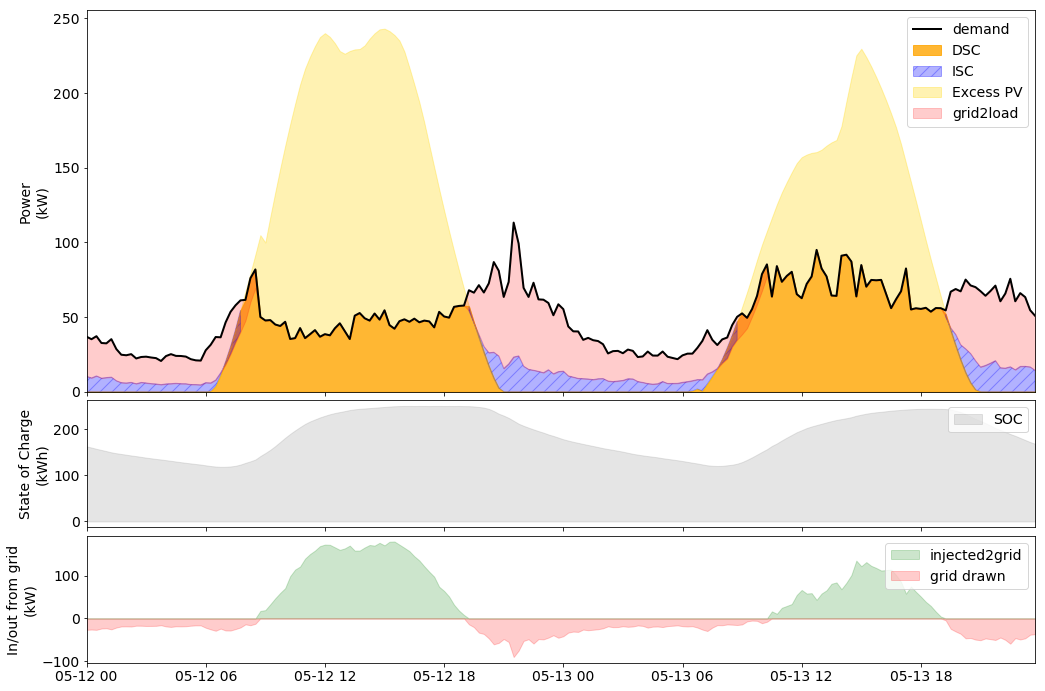

In [16]:
a=p2p.plot_dispatch_comm(df_out.PV*PV_size_comm, df_out.loc[:,df_com.iloc[:,0]].sum(axis=1),out_comm_final, week=20,flag=0,save=True)

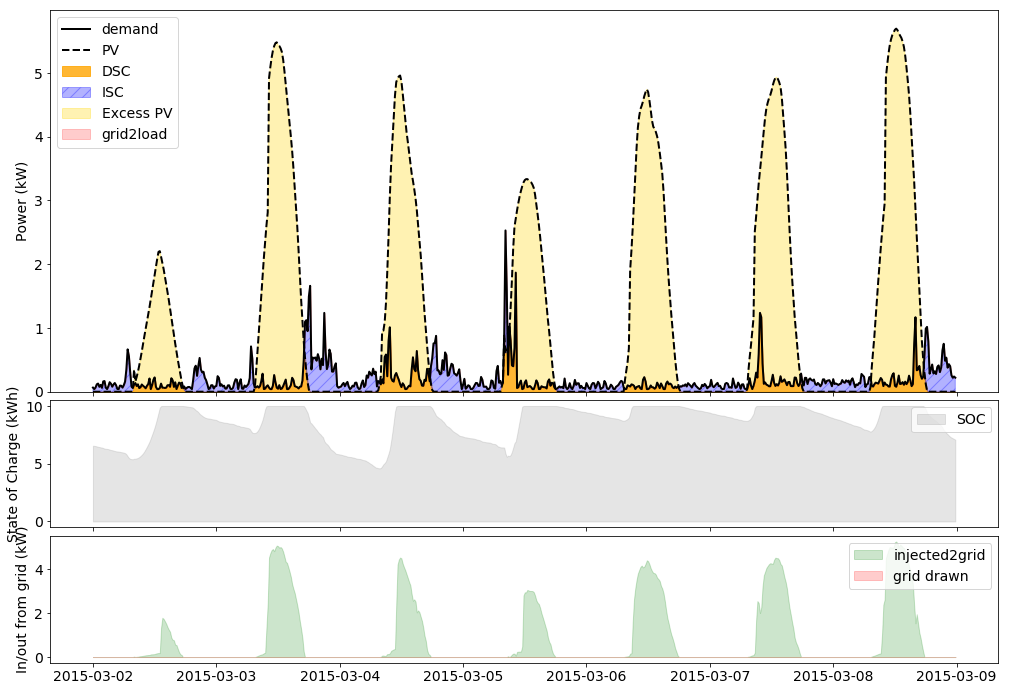

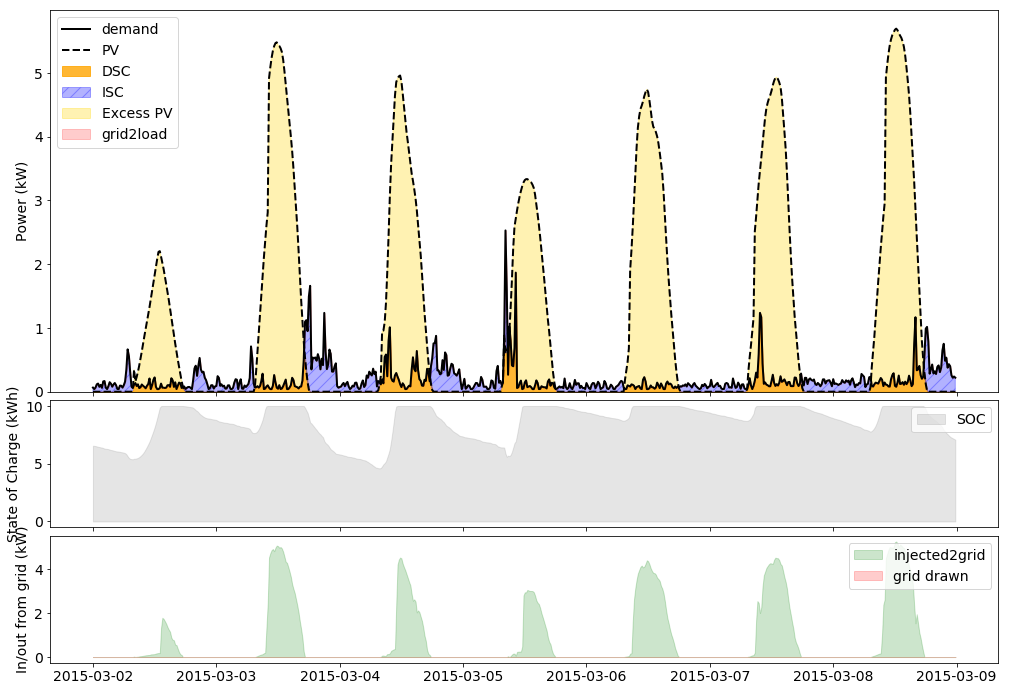

In [17]:
# Single household test
hhNumber=18
inv_size=max(selection.PV_size[hhNumber],param_tech['MaxPower'])
out_aux=p2p.dispatch_max_sc(df_out.PV*selection.PV_size[hhNumber],df_out.loc[:,str(selection.name[hhNumber])],
                        inv_size,param_tech)

out_aux.keys()

(out_aux['pv2store']-out_aux['store2inv']).sum()*timestep

selection.PV_size[hhNumber]

aux=p2p.print_analysis_prices(df_out.PV*selection.PV_size[hhNumber],df_out.loc[:,str(selection.name[hhNumber])],retail_price_sc,
                      export_price_sc,param_tech,out_aux,hhNumber)

p2p.plot_dispatch(df_out.PV*selection.PV_size[hhNumber],df_out.loc[:,str(selection.name[hhNumber])],out_aux,week=10)

# -------------------------------------------------------------------------

In [18]:
df_bhv=pd.read_csv('../Input/table_bhv.csv',index_col=[0])

# Here should come the selection of hh

In [22]:
if predet_bhv==False:
    tmp_pair=pd.DataFrame(map(lambda X: dict({'id':X[0],'hh':X[1]}), list(zip(list(selection.name.unique()),list(df_bhv[df_bhv.will==1].hh.unique())))))
elif predet_bhv=='high':
    df_sel=df_bhv[df_bhv.will]
    upper=df_sel.groupby('hh').sum().sell.median()+df_sel.groupby('hh').sum().sell.std()
    sell_group=df_sel.groupby('hh').sum().sell
    high_sell_group=sell_group[sell_group>upper]
    tmp_pair=pd.DataFrame(map(lambda X: dict({'id':X[0],'hh':X[1]}), list(zip(list(selection.name.unique()),cycle(list(df_bhv[df_bhv.hh.isin(high_sell_group.index)].hh.unique()))))))
elif predet_bhv=='low':
    df_sel=df_bhv[df_bhv.will]
    lower=df_sel.groupby('hh').sum().sell.median()-df_sel.groupby('hh').sum().sell.std()
    sell_group=df_sel.groupby('hh').sum().sell
    low_sell_group=sell_group[sell_group<lower]
    tmp_pair=pd.DataFrame(map(lambda X: dict({'id':X[0],'hh':X[1]}), list(zip(list(selection.name.unique()),cycle(list(df_bhv[df_bhv.hh.isin(low_sell_group.index)].hh.unique()))))))
    


In [23]:


df_bhv_paired=pd.merge(left=tmp_pair, right=df_bhv, left_on='hh', right_on='hh')

df_bhv_paired.Price/=100

df_bhv_paired['Price_binned']=(np.digitize(df_bhv_paired.Price,[0.04,0.12,0.20,0.28]))

df_bhv_paired['SOC_binned']=(np.digitize(df_bhv_paired.SOC,[30,60,90]))

In [24]:
param_tech.update({'Price':[0.04,0.12,0.20,0.28]})
param_tech_comm.update({'Price':[0.04,0.12,0.20,0.28]})
param_tech_no_batt.update({'Price':[0.04,0.12,0.20,0.28]})

In [25]:
df_prices=p2p.price_generation(out_comm_final, param_tech_no_batt)
prices_binned=np.digitize(df_prices,bins=[0.04,0.12,0.20,0.28])
prices_binned[prices_binned==0]=1

In [26]:

nested_out_p2p={}
#print_analysis_prices(pv, demand,retail,export, param, E,isCommunity=False,hh=None,print_all=False):

j=0
k=0
PV_size_comm=0
for i in selection.index:
    print(i, end='')
    if selection.loc[i,'sub_'+str(pv_penetration)+'_100']:#all with PV
        inv_size=max(param_tech['MaxPower'],selection.PV_size[i])#selection.PV_size[i]/ILR
        PV_size_comm+=selection.PV_size[i]

        if selection.loc[i,'sub_'+str(pv_penetration)+'_'+str(batt_penetration)]: #if battery
            nested_out_p2p[i]=p2p.dispatch_max_sc_bhv(df_out.PV*selection.PV_size[i],df_out.loc[:,str(selection.name[i])],
                                              df_bhv_paired[df_bhv_paired.id==selection.name[i]],prices_binned,inv_size,param_tech)

            j+=1
        else: #if only PV battery=0 kWh, thus no bhv needed
            nested_out_p2p[i]=p2p.dispatch_max_sc(df_out.PV*selection.PV_size[i],df_out.loc[:,str(selection.name[i])],
                                          inv_size,param_tech_no_batt)

            k+=1
    else: #No PV, thus no bhv needed
        nested_out_p2p[i]=p2p.dispatch_max_sc(df_out.PV*0,df_out.loc[:,str(selection.name[i])],0,param_tech_no_batt)



0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

In [27]:
#get all the data in a single dict
pv2inv_p2p=pd.DataFrame()
res_pv_p2p=pd.DataFrame()
pv2store_p2p=pd.DataFrame()
inv2load_p2p=pd.DataFrame()
grid2load_p2p=pd.DataFrame()
store2inv_p2p=pd.DataFrame()
inv2curt_p2p=pd.DataFrame()
LevelOfCharge_p2p=pd.DataFrame()
inv2grid_p2p=pd.DataFrame()
store2grid_p2p=pd.DataFrame()
store2load_p2p=pd.DataFrame()
batt_losses_p2p=pd.DataFrame()
inv_losses_p2p=pd.DataFrame()
flagsell=pd.DataFrame()
for i in nested_out_p2p.keys():
    pv2inv_p2p['pv2inv'+str(i)]=nested_out_p2p[i]['pv2inv']
    inv2curt_p2p['inv2curt'+str(i)]=nested_out_p2p[i]['inv2curt']
    pv2store_p2p['pv2store'+str(i)]=nested_out_p2p[i]['pv2store']
    inv2load_p2p['inv2load'+str(i)]=nested_out_p2p[i]['inv2load']
    batt_losses_p2p['batt_losses'+str(i)]=nested_out_p2p[i]['batt_losses']
    inv_losses_p2p['inv_losses'+str(i)]=nested_out_p2p[i]['inv_losses']
    store2inv_p2p['store2inv'+str(i)]=nested_out_p2p[i]['store2inv']
    LevelOfCharge_p2p['LevelOfCharge'+str(i)]=nested_out_p2p[i]['LevelOfCharge']
    res_pv_p2p['res_pv'+str(i)]=nested_out_p2p[i]['res_pv']#not important, recalculated later
    inv2grid_p2p['inv2grid'+str(i)]=nested_out_p2p[i]['inv2grid']#not important, recalculated later
    grid2load_p2p['grid2load'+str(i)]=nested_out_p2p[i]['grid2load']#not important, recalculated later
    store2load_p2p['store2load'+str(i)]=nested_out_p2p[i]['store2load']
    store2grid_p2p['store2grid'+str(i)]=nested_out_p2p[i]['store2grid']
    flagsell['flag_sell'+str(i)]=nested_out_p2p[i]['flag_sell']
nested_dict_p2p={'pv2inv':pv2inv_p2p.sum(axis=1),'pv2store':pv2store_p2p.sum(axis=1),'inv2load':inv2load_p2p.sum(axis=1),
             'grid2load':grid2load_p2p.sum(axis=1),'store2inv':store2inv_p2p.sum(axis=1),'LevelOfCharge':LevelOfCharge_p2p.sum(axis=1),
             'inv2grid':inv2grid_p2p.sum(axis=1),'res_pv':res_pv_p2p.sum(axis=1),'store2grid':store2grid_p2p.sum(axis=1),
             'store2load':store2load_p2p.sum(axis=1),'inv_losses':inv_losses_p2p.sum(axis=1),
             'batt_losses':batt_losses_p2p.sum(axis=1),'inv2curt':inv2curt_p2p.sum(axis=1),'flagsell':flagsell.sum(axis=1)}

In [28]:
out_comm_res_p2p=p2p.dispatch_max_sc(nested_dict_p2p['inv2grid'],nested_dict_p2p['grid2load'],1e10,param_tech_comm)

In [29]:
out_comm_final_p2p={}
out_comm_final_p2p['pv2inv']=nested_dict_p2p['pv2inv'] # DC from hh with PV
out_comm_final_p2p['pv2store']=nested_dict_p2p['pv2store'] # DC PV 2 batt from hh with PV
out_comm_final_p2p['inv2load']=(nested_dict_p2p['inv2load']+out_comm_res_p2p['inv2load']) # AC from all hh
out_comm_final_p2p['store2inv']=nested_dict_p2p['store2inv'] # DC  from hh with PV and batt
out_comm_final_p2p['LevelOfCharge']=nested_dict_p2p['LevelOfCharge'] # kWh  from hh with PV and batt
out_comm_final_p2p['res_pv']=out_comm_res_p2p['res_pv'] # DC  from hh with PV
out_comm_final_p2p['inv2grid']=out_comm_res_p2p['inv2grid'] # AC from hh with PV
out_comm_final_p2p['grid2load']=out_comm_res_p2p['grid2load'] # AC  from all hh
out_comm_final_p2p['inv2curt']=nested_dict_p2p['inv2curt'] # DC  from hh with PV
out_comm_final_p2p['batt_losses']=nested_dict_p2p['batt_losses']
out_comm_final_p2p['inv_losses']=nested_dict_p2p['inv_losses']
out_comm_final_p2p['store2grid']=nested_dict_p2p['store2grid'] # AC
out_comm_final_p2p['store2load']=nested_dict_p2p['store2load'] # AC
out_comm_final_p2p['LevelOfCharge']=nested_dict_p2p['LevelOfCharge']
out_comm_final_p2p['PV_size_comm']=PV_size_comm
out_comm_final_p2p['df']=df_out
out_comm_final_p2p['param_tech']=param_tech
out_comm_final_p2p['nested_dict']=nested_dict_p2p
out_comm_final_p2p['selection']=selection
out_comm_final_p2p['flagsell']=nested_dict_p2p['flagsell']

In [30]:
result_out_p2p={}
#print_analysis_prices(pv, demand,retail,export, param, E,isCommunity=False,hh=None,print_all=False):
sum_bill_p2p=0

j=0
k=0
for i in selection.index:
    print(i, end='')
    if selection.loc[i,'sub_'+str(pv_penetration)+'_100']:#all with PV
        inv_size=max(param_tech['MaxPower'],selection.PV_size[i])#selection.PV_size[i]/ILR

        if selection.loc[i,'sub_'+str(pv_penetration)+'_'+str(batt_penetration)]: #if battery
            result_out_p2p[i]=p2p.print_analysis_prices(df_out.PV*selection.PV_size[i],df_out.loc[:,str(selection.name[i])],df_prices,df_prices,
                          param_tech,
                                                        nested_out_p2p[i],isCommunity=False,hh=i,print_all=False)
            result_out_p2p[i]['bill']=p2p.bill_hh_p2p(df_out.PV*selection.PV_size[i],df_out.loc[:,str(selection.name[i])],df_prices,export_price_sc,
                          out_comm_final_p2p['inv2grid'], nested_out_p2p[i],param_tech)
            result_out_p2p[i]['type']='PV_batt'
            j+=1
        else: #if only PV battery=0 kWh, thus no bhv needed
            result_out_p2p[i]=p2p.print_analysis_prices(df_out.PV*selection.PV_size[i],df_out.loc[:,str(selection.name[i])],df_prices,df_prices,
                          param_tech_no_batt, nested_out_p2p[i],isCommunity=False,hh=i,print_all=False)
            result_out_p2p[i]['bill']=p2p.bill_hh_p2p(df_out.PV*selection.PV_size[i],df_out.loc[:,str(selection.name[i])],df_prices,export_price_sc,
                          out_comm_final_p2p['inv2grid'], nested_out_p2p[i],param_tech_no_batt)
            result_out_p2p[i]['type']='PV'
            k+=1
    else: #No PV, thus no bhv needed

        result_out_p2p[i]=p2p.print_analysis_prices(df_out.PV*0,df_out.loc[:,str(selection.name[i])],df_prices,df_prices,
                          param_tech_no_batt, nested_out_p2p[i],isCommunity=False,hh=i,print_all=False)
        result_out_p2p[i]['bill']=p2p.bill_hh_p2p(df_out.PV*0,df_out.loc[:,str(selection.name[i])],df_prices,export_price_sc,
                          out_comm_final_p2p['inv2grid'], nested_out_p2p[i],param_tech_no_batt)
        result_out_p2p[i]['type']='No'

    sum_bill_p2p+=result_out_p2p[i]['bill']

out_p2p=p2p.print_analysis_prices(df_out.PV*PV_size_comm,df_out.loc[:,df_com.iloc[:,0]].sum(axis=1),retail_price_sc,
                      export_price_sc,param_tech_no_batt,out_comm_final_p2p,isCommunity=True,print_all=False) #Community bill need to be calculated afterwards

out_p2p['bill']=sum_bill_p2p

out_p2p_hh=pd.DataFrame()
out_p2p_hh=out_p2p_hh.append([pd.DataFrame(result_out_p2p[i],index=[i]) for i in range(len(result_out))])
out_sc_hh=pd.DataFrame()
out_sc_hh=out_sc_hh.append([pd.DataFrame(result_out[i],index=[i]) for i in range(len(result_out))])

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

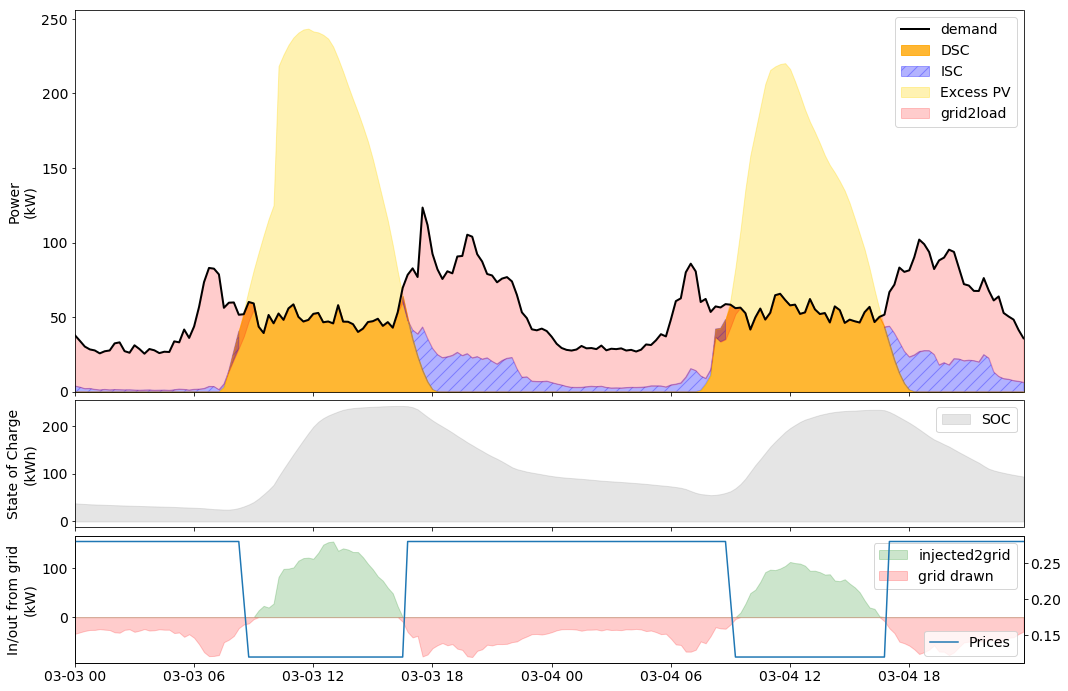

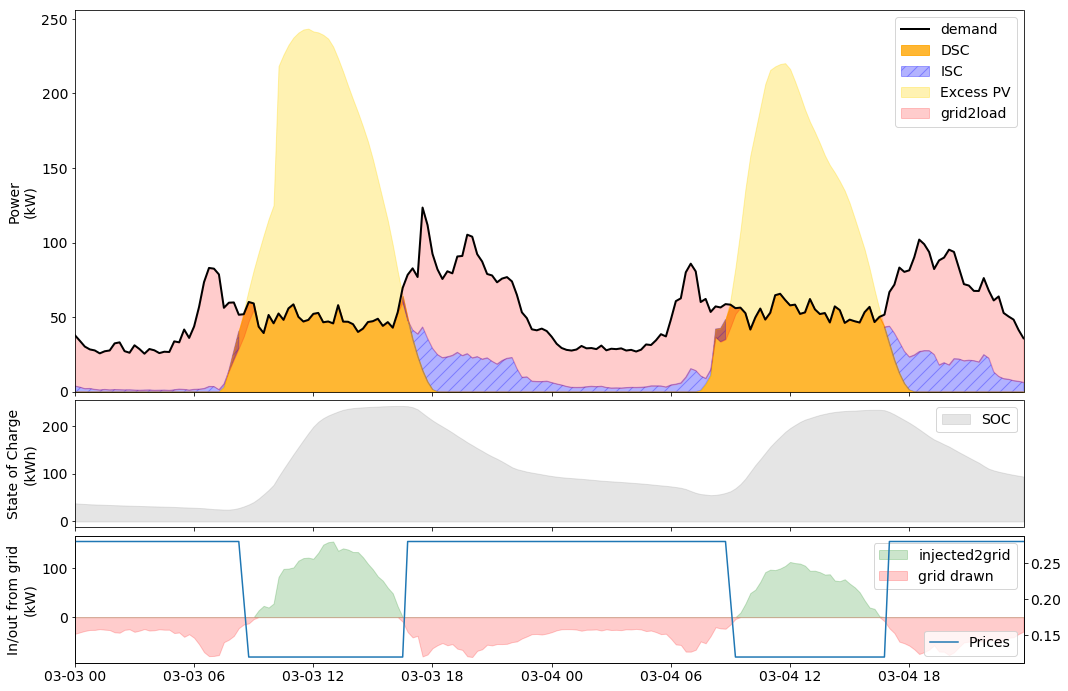

In [31]:
p2p.plot_dispatch_comm(df_out.PV*PV_size_comm, df_out.loc[:,df_com.iloc[:,0]].sum(axis=1),out_comm_final_p2p, week=10,flag=0,prices=df_prices,save=False)

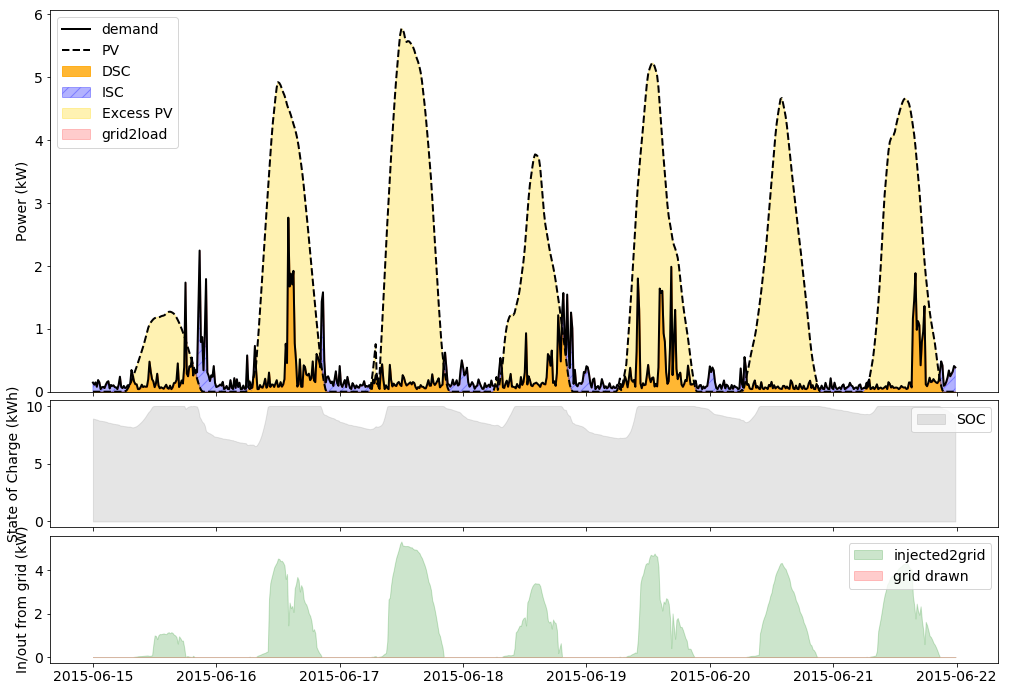

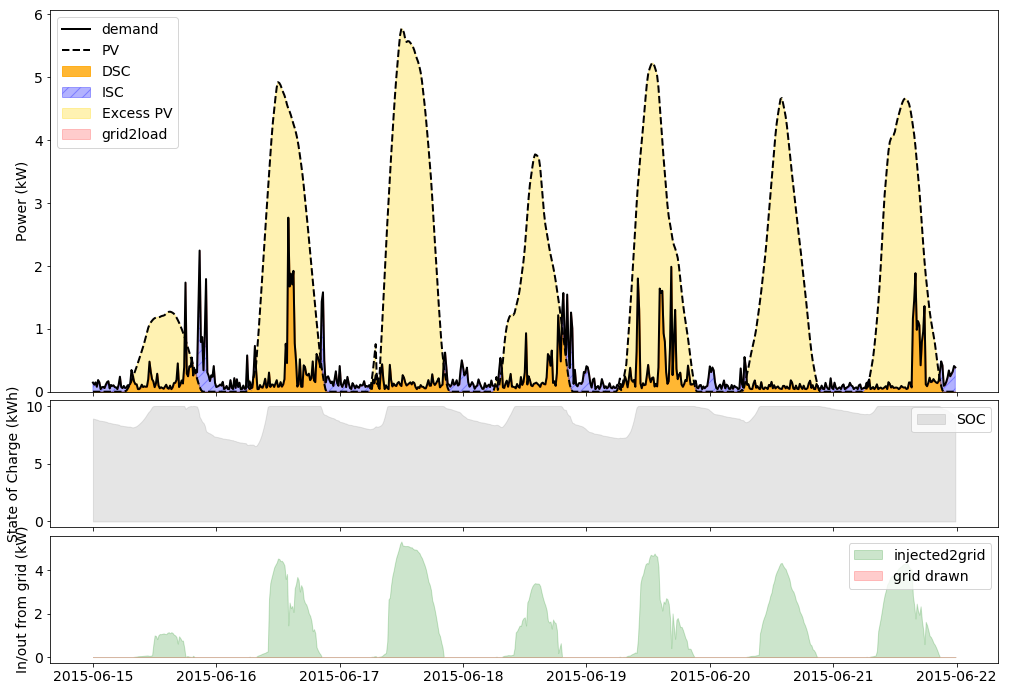

In [32]:
# Single household test
hhNumber=18
inv_size=max(param_tech['MaxPower'],selection.PV_size[hhNumber])#selection.PV_size[i]/ILR
out_aux=p2p.dispatch_max_sc_bhv(df_out.PV*selection.PV_size[hhNumber],df_out.loc[:,str(selection.name[hhNumber])],
                             df_bhv_paired[df_bhv_paired.id==selection.name[hhNumber]],prices_binned,inv_size,param_tech)

out_aux.keys()

(out_aux['pv2store']-out_aux['store2inv']).sum()*timestep

selection.PV_size[hhNumber]

p2p.print_analysis_prices(df_out.PV*selection.PV_size[hhNumber],df_out.loc[:,str(selection.name[hhNumber])],prices_binned,export_price_sc,param_tech,out_aux)

p2p.plot_dispatch(df_out.PV*selection.PV_size[hhNumber],df_out.loc[:,str(selection.name[hhNumber])],out_aux,week=25)

# --------------------------------------------------------------

# Technical indicators: SSR, SCR, EBI, PtP

### The higher the better

In [33]:
print(out_p2p['SSR']>out_sc['SSR'])
print(out_p2p['SSR']-out_sc['SSR'])

True
0.8496348230851467


In [34]:
print(out_p2p['SCR']>out_sc['SCR'])
print(out_p2p['SCR']-out_sc['SCR'])

True
0.8179679786358847


In [35]:

a=pd.DataFrame(out_comm_final_p2p['grid2load']-out_comm_final_p2p['inv2grid'])#create the grid exchange column
b=pd.DataFrame(out_comm_final['grid2load']-out_comm_final['inv2grid'])#create the grid exchange column


sc_peak=(b.groupby([b.index.month,b.index.day]).max()-b.groupby([b.index.month,b.index.day]).min()).reset_index()#peak-to-peak difference inside sc per day
p2p_peak=(a.groupby([a.index.month,a.index.day]).max()-a.groupby([a.index.month,a.index.day]).min()).reset_index()#peak-to-peak difference inside p2p per day
out_peak=pd.concat([sc_peak,p2p_peak],axis=1,ignore_index=True)
out_peak.columns=['Month','Day','SC','Month2','Day2','P2P']

p2p_week=(out_comm_final_p2p['grid2load']-out_comm_final_p2p['inv2grid']).groupby([out_comm_final['grid2load'].index.dayofweek,
                                             out_comm_final_p2p['grid2load'].index.hour]).mean()
sc_week=(out_comm_final['grid2load']-out_comm_final['inv2grid']).groupby([out_comm_final['grid2load'].index.dayofweek,
                                         out_comm_final['grid2load'].index.hour]).mean()


p2p_day=(out_comm_final_p2p['grid2load']-out_comm_final_p2p['inv2grid']).groupby([out_comm_final_p2p['grid2load'].index.hour]).mean()
sc_day=(out_comm_final['grid2load']-out_comm_final['inv2grid']).groupby([out_comm_final['grid2load'].index.hour]).mean()


week_power=pd.concat([p2p_week.rename('p2p'),sc_week.rename('sc')],axis=1)

day_power=pd.concat([p2p_day.rename('p2p'),sc_day.rename('sc')],axis=1)

The P2P peak-to-peak measure is lower than in the SC one

In [36]:
(p2p_peak<sc_peak).sum()[0]/365

0.6273972602739726

### The lower the better (i.e., false is good)

#### This indicators give special attention to the maximum peak across the year.

In [37]:
print(out_p2p['ADME']>out_sc['ADME'])# False is good
print(out_p2p['ADME']-out_sc['ADME'])

False
-0.0004917912025645954


In [38]:
print(out_p2p['ADMD']>out_sc['ADMD'])
print(out_p2p['ADMD']-out_sc['ADMD'])

False
0.0


In [39]:
print(out_p2p['EPARI']>out_sc['EPARI'])
print(out_p2p['EPARI']-out_sc['EPARI'])

True
0.085031100930677


In [40]:
print(out_p2p['EPARI'])
print(out_sc['EPARI'])

4.866598841588945
4.781567740658268


# Social indicators: PWI

## "Participation willingness index" (Zhou et al.) 

In [41]:
PWI=(((pd.DataFrame([result_out[i]['bill'] for i in range(community_size)])-pd.DataFrame([result_out_p2p[i]['bill'] for i in range(community_size)]))>0).sum()/community_size).values[0]

In [42]:
PWI

1.0

# Gini RSV index

In [43]:
def Gini_rsv(y,w=None):
    '''takes a np array and the weights if it is the case and return the GINI index for negative income
    Based on https://rdrr.io/cran/GiniWegNeg/src/R/Gini_RSV.R
    '''    
    arg_sorted=np.argsort(y)
    y=y[arg_sorted]
    if w is None:
        w=np.ones(len(y))
    else:
        w=w[arg_sorted]
        
    N=sum(w)
    yw=y*w
    C_i=np.cumsum(w)
    num_1=np.sum(yw*C_i)
    num_2=np.sum(yw)
    num_3=np.sum(yw*w)
    G_num=(2/N**2)*num_1-(1/N)*num_2-(1/N**2)*num_3
    
    T_neg=np.sum(yw[yw<0])
    T_pos=np.sum(yw)+np.abs(T_neg)
    n_RSV=(2*(T_pos+(np.abs(T_neg)))/N)
    mean_RSV=(n_RSV/2)
    G_RSV=(1/mean_RSV)*G_num
    return G_RSV.round(2)
    

In [44]:
aux=pd.DataFrame(np.array([[result_out[i]['bill'] for i in range(community_size)],[result_out_p2p[i]['bill'] for i in range(community_size)],[result_out[i]['type'] for i in range(community_size)]]).T,
             columns=['SC','P2P','type'])

In [45]:
aux.loc[aux.type=='PV_batt','weight']=4
aux.loc[aux.type=='PV','weight']=2
aux.loc[aux.type=='No','weight']=1

In [46]:
Gini_rsv(np.array(aux.SC.astype(float)),aux.weight)

0.61

In [47]:
Gini_rsv(np.array(aux.P2P.astype(float)),aux.weight)

0.63

## Jain's Fairness index from TCP fairness

In [48]:
sum([result_out[i]['bill'] for i in range(community_size)])**2/(community_size*sum([result_out[i]['bill']**2 for i in range(community_size)])).round(2)

0.5707598780069575

In [49]:
sum([result_out_p2p[i]['bill'] for i in range(community_size)])**2/(community_size*sum([result_out_p2p[i]['bill']**2 for i in range(community_size)])).round(2)

0.5218290096722497